Purpose: To investigate what fraction of the PHAs (or NEOs) might be discovered before or during LSST operations by other telescope, and then add these to LSST's total to see the effect of LSST + previous discoveries. 

As we use synthetic model populations (not actual populations) and do not know the survey pointing history for previous surveys, we simulate what would have been "previously discovered" by taking our model population and identifying a V magnitude threshhold which matches approximately what is known now or what will be known at the start of LSST operations. 

As a proxy for simulating the entire population + pointing histories for existing surveys, we can assume that all NEOs larger than 140m which get brighter than a given V magnitude threshhold will be discovered. Spacewatch has been in operation since 1984, CSS has been a considerable influence in NEO discovery since 2005, etc. According to the JPL NEO discovery page (http://neo.jpl.nasa.gov/stats/) we could estimate conservatively that discovery of 140m NEOs started in earnest in 2000 -- implying (a conservative) 15 years to reach the current 25% level (and the discovery rate of 140m and larger NEOs seems roughly constant over that time period, with a recent uptick of about 20% per year).  GMS16 (https://arxiv.org/pdf/1604.03444v1.pdf) indicates that the current completeness of NEOs larger than 140m is about 25% (Mainzer et al 2011) and is expected to be 43% when LSST comes online.

Thus we take our sample of NEOs, integrate their orbits over 15 years (generating ephemerides once per night), and look at their peak brightness over that time period. We then choose a peak brightness threshhold that corresponds to detecting 25% of the total NEOs larger than 140m (H=22). 

After going through the process shown in the cells below, I find the threshhold should be V=20.0 to match current completeness after 15 years of operations, and that the expected completeness if this same rate continues should be 30% at the start of LSST. However, new assets online (such as PanSTARRS) mean that the limiting magnitude should be adjusted to a fainter limit: we use V=22 as a default.

In [1]:
# Set up basics.
import os 
import numpy as np
import numpy.ma as ma
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
# Set up MAF
import lsst.sims.maf.metrics as metrics
import lsst.sims.maf.slicers as slicers
import lsst.sims.maf.plots as plots
import lsst.sims.maf.db as db
import lsst.sims.maf.metricBundles as mmb
import lsst.sims.maf.utils as utils

import sys
try:
    # remove a conflict on my personal system
    sys.path.remove('/Users/lynnej/work/lsst')
except ValueError:
    pass
sys.path.append(os.path.join(os.getenv('SIMS_MAF_DIR'), 'bin.src'))
import movingObjects as moO

Set up some basic information that we need to define orbit parameters and metric ranges.

In [6]:
orbitFile = {}
orbitFile['pha'] = 'orbits/pha_5k'
orbitFile['neo'] = 'orbits/neo_5k'

In [9]:
Hmark = 22
Hrange = np.arange(11, 28.5, 0.5)
Hidx = np.where(Hrange == 22)[0]
outDir = 'other_telescopes'
if not (os.path.isdir(outDir)):
    os.makedirs(outDir)

If this notebook was previously run, or you have the information available, you can read back in the previous evaluation of the peak magnitudes and time of 'discovery' (first time V>20.0) for the 15 years from start of surveys to now, the 22 years from start of surveys to start of LSST, and the same information during the LSST survey.

In [10]:
# Read previously calculated times of discovery for LSST, for the 15 years up to 'now', for the 22 years between 
# now and LSST start, for the 10 years of LSST (for other resources) and the times of discovery for LSST back from disk

# Set up the moving object slicers for each of these ephemeride files. -- without obs data.
slicerEphsN =  {}
for t in ['neo', 'pha']:
    slicerEphsN[t] = moO.setupSlicer(orbitFile[t], Hrange, obsFile=None)

In [15]:
import os
flist = os.listdir(outDir)
knownBundle = {}
peakVBundle = {}
m1 = metrics.KnownObjectsMetric()
m2 = metrics.PeakVMagMetric()
for tp in ['neo', 'pha']:
    knownBundle[tp] = {}
    for i in [0, 1, 2, 3]:
        knownBundle[tp][i] = mmb.MoMetricBundle(m1, slicerEphsN[t], None, 
                                                runName="Previously known %d" % i, metadata=t)
        froot = 'Previously_known_%d_KnownObjects_%s_MOOB' % (i, tp)
        knownBundle[tp][i].fileRoot = froot
        moO.readMetricValues(knownBundle[tp][i], outDir)
    peakVBundle[tp] = mmb.MoMetricBundle(m2, slicerEphsN[t], None, runName="Previously Known", metadata=t)
    froot = 'PeakVMag_PeakVMag_%s_MOOB' % (tp)
    peakVBundle[tp].fileRoot = froot
    moO.readMetricValues(peakVBundle[tp], outDir)

(0, 2000)

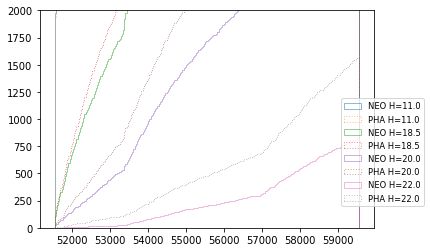

In [17]:
t = np.arange(51544., 59580., 30.)
t1 = knownBundle['neo'][0].metricValues.swapaxes(0, 1)
t2 = knownBundle['pha'][0].metricValues.swapaxes(0, 1)
for Hidx in [0, 15, 18, 22]:
    n, b, p = plt.hist(t1[Hidx].compressed(), bins=t, cumulative=True, alpha=0.5, 
                       histtype='step', label='NEO H=%.1f' % Hrange[Hidx])
    n, b, p = plt.hist(t2[Hidx].compressed(), bins=t, cumulative=True, alpha=0.5, 
                       histtype='step', linestyle=':', label='PHA H=%.1f' % Hrange[Hidx])
plt.legend(loc=(0.9, 0.1), fontsize='small')
plt.ylim(0, 2000)

In [21]:
times = np.arange(51544, 65055+15, 30)
summaryMetric = metrics.MoCompletenessAtTimeMetric(times=times, Hindex=0.33, Hval=22)

for t in ['neo', 'pha']:
    for i in (0, 1, 2, 3):
        knownBundle[t][i].setSummaryMetrics(summaryMetric)
        knownBundle[t][i].computeSummaryStats()

In [22]:
# Actual rate from CNEOS page (NEA-140m and larger)
import pandas as pd
import datetime
cneos_data = pd.read_table('actual_rate_cneos.dat', delim_whitespace=True)
neo140rate = cneos_data['NEA140'] / 25000.0
cneos_data['pha'] = neo140rate
cneos_data['Date'] = pd.to_datetime(cneos_data.Date)
d = cneos_data.query('Date > 2000')
t2015 = pd.to_datetime(['2015-01-01'])
dyrs = (cneos_data.Date - t2015) / datetime.timedelta(days=365.25) + 2015

Eff 5\%, 60 deg, bump 10\% [ 0.28470906] [ 0.41691736] [ 0.55842246]
Eff 5\%, 100 deg, bump 10\% [ 0.27063447] [ 0.39524768] [ 0.5354122]
Eff 5\%, 100 deg, bump 22.2 + 10\% [ 0.26967508] [ 0.39750471] [ 0.56056718]
Eff 5\%, 100 deg, bump 22.2 + 20\% [ 0.27031594] [ 0.39709962] [ 0.56872793]


Text(0.5,1,'Cumulative completeness for NEO with $H<22$')

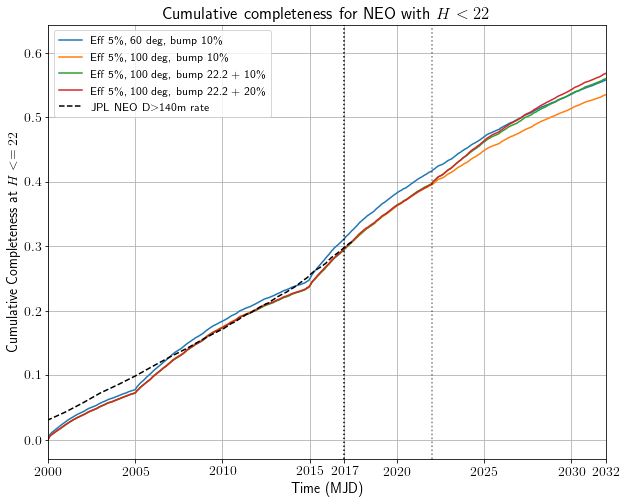

In [28]:
plt.figure(figsize=(10,8))
plt.rc('text', usetex=True)      
plt.rc('font', size=14)
years = (times - 57023) / 365.25 + 2015
for kb, bundleNum in zip((knownBundle['neo'][0], knownBundle['neo'][1], knownBundle['neo'][2], knownBundle['neo'][3]), 
                    ('Eff 5\%, 60 deg, bump 10\%', 'Eff 5\%, 100 deg, bump 10\%', 
                     'Eff 5\%, 100 deg, bump 22.2 + 10\%',  'Eff 5\%, 100 deg, bump 22.2 + 20\%')):
    comp = np.zeros(len(times), float)
    for i, t in enumerate(times):
        comp[i] = kb.summaryValues['CumulativeCompleteness@Time'][i][1]
    plt.plot(years, comp, label=r'%s' % (bundleNum))
    #plt.plot(years, comp*0.6, linestyle=':')
    idx2016 = np.where(np.abs(times - 57388) == np.abs(times - 57388).min())
    idx2022 = np.where(np.abs(times - 59580) == np.abs(times - 59580).min())
    idx2032 = np.where(np.abs(times - 63232) == np.abs(times - 63232).min())
    print(bundleNum, comp[idx2016], comp[idx2022], comp[idx2032])
plt.plot(dyrs, neo140rate, color='k', linestyle='--', label=r'JPL NEO D$>$140m rate')
plt.xlim(2000, 2032)
plt.xticks([2000, 2005, 2010, 2015, 2017, 2020, 2025, 2030, 2032])
#plt.ylim(0, 0.5)
plt.legend(loc='upper left', fancybox=True, fontsize='smaller', numpoints=1)
plt.xlabel('Time (MJD)')
plt.ylabel('Cumulative Completeness at $H<=22$')
plt.axvline(2017, color='k', linestyle=':')
plt.axvline(2022, color='k', linestyle=':', alpha=0.5)
#plt.axvline(2032, color='k', linestyle=':', alpha=0.5)
plt.grid(True)
plt.title('Cumulative completeness for NEO with $H<22$')


[ 0.26967508] [ 0.39750471] [ 0.56056718]


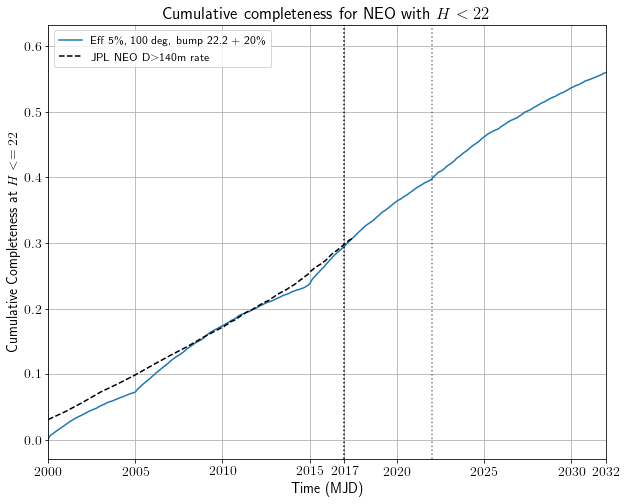

In [48]:
plt.figure(figsize=(10,8))
plt.rc('text', usetex=True)      
plt.rc('font', size=14)
years = (times - 57023) / 365.25 + 2015
kb = knownBundle['neo'][2]
comp = np.zeros(len(times), float)
for i, t in enumerate(times):
    comp[i] = kb.summaryValues['CumulativeCompleteness@Time'][i][1]
plt.plot(years, comp, label=r'%s' % (bundleNum))
#plt.plot(years, comp*0.6, linestyle=':')
idx2016 = np.where(np.abs(times - 57388) == np.abs(times - 57388).min())
idx2022 = np.where(np.abs(times - 59580) == np.abs(times - 59580).min())
idx2032 = np.where(np.abs(times - 63232) == np.abs(times - 63232).min())
print(comp[idx2016], comp[idx2022], comp[idx2032])
plt.plot(dyrs, neo140rate, color='k', linestyle='--', label=r'JPL NEO D$>$140m rate')
plt.xlim(2000, 2032)
plt.xticks([2000, 2005, 2010, 2015, 2017, 2020, 2025, 2030, 2032])
#plt.ylim(0, 0.5)
plt.legend(loc='upper left', fancybox=True, fontsize='smaller', numpoints=1)
plt.xlabel('Time (MJD)')
plt.ylabel('Cumulative Completeness at $H<=22$')
plt.axvline(2017, color='k', linestyle=':')
plt.axvline(2022, color='k', linestyle=':', alpha=0.5)
#plt.axvline(2032, color='k', linestyle=':', alpha=0.5)
plt.grid(True)
plt.title('Cumulative completeness for NEO with $H<22$')
plt.savefig('other_surveys_completeness.pdf', format='pdf')
known = {}
known['neo'] = knownBundle['neo'][2]
known['pha'] = knownBundle['pha'][2]

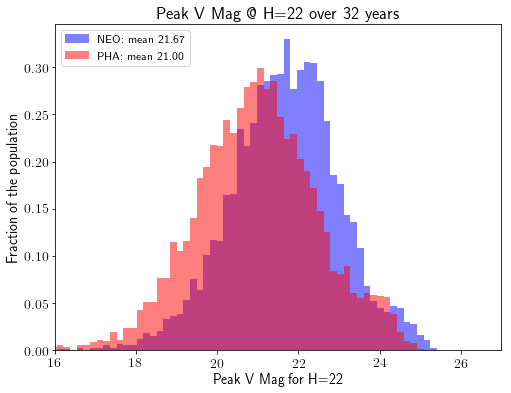

In [32]:
# Just a plot to show why completeness different for neos vs phas
Hidx = np.where(Hrange == 22)[0]
lpha = np.swapaxes(peakVBundle['pha'].metricValues, 0, 1)[Hidx][0]
lneo = np.swapaxes(peakVBundle['neo'].metricValues, 0, 1)[Hidx][0]

plt.figure(figsize=(8, 6))
meanV = np.mean(lneo)
n, b, p = plt.hist(lneo, bins=60, normed=True, color='b', alpha=0.5, label='NEO: mean %.2f' % meanV)
meanV = np.mean(lpha)
n, b, p = plt.hist(lpha, bins=b, normed=True, color='r', alpha=0.5, label='PHA: mean %.2f' % meanV)
plt.xlim(16, 27)
plt.legend(loc='upper left', fontsize='smaller')
plt.title('Peak V Mag @ H=22 over 32 years')
plt.xlabel('Peak V Mag for H=22')
plt.ylabel('Fraction of the population')
plt.savefig('prev_peakVmag.pdf')

So that tells us about what could have been discovered prior to LSST (and at the present time). 

Now let's look at what LSST would have found, with our more realistic discovery criteria (3 nights of pairs, within 30 days).  Read the discovery times data back from disk.

In [67]:
opsims = ['minion_1016', 'astro_lsst_01_1016', 'astro_lsst_01_1015', 'astro_lsst_01_1017', 'astro-lsst-01_2013']
#opsims = ['astro_lsst_01_1016', 'astro_lsst_01_1015']

maxYears = 12
nyears = np.arange(2, maxYears+1, 2)
nyears = np.concatenate([[1], nyears])
if maxYears not in nyears:
    nyears = np.concatenate([nyears, [maxYears]])

# Read from disk.
mtmp = metrics.DiscoveryMetric(nObsPerNight=2, tMin=0, tMax=90./60./24., nNightsPerWindow=3, tWindow=30)
metric = metrics.Discovery_TimeMetric(mtmp)
timebundles = {}
strategies = ['3 pairs in 12 nights', '3 pairs in 15 nights', '3 pairs in 20 nights', 
              '3 pairs in 30 nights', '4 pairs in 20 nights']
types = ['neo', 'pha']
for opsim in opsims:
    timebundles[opsim] = {}
    for t in types:
        timebundles[opsim][t] = {}
        for strategy in strategies:
            timebundles[opsim][t][strategy] = mmb.MoMetricBundle(metric, slicerEphsN[t], None, 
                                                                 runName=opsim, metadata=t)
            froot = '%s_Discovery_Time_%s_5k_%s_MOOB' % (opsim, t, strategy.replace(' ', '_'))
            timebundles[opsim][t][strategy].fileRoot = froot
            moO.readMetricValues(timebundles[opsim][t][strategy], 'discovery') 

In [68]:
Hrange2 = timebundles['astro_lsst_01_1016']['neo'][strategies[0]].slicer.Hrange
if np.any(Hrange2 != kb.slicer.Hrange):
    print('no')

In [69]:
def combineTimes(discTimes1, discTimes2):
    discTimes = np.where(discTimes1.filled(100000) <= discTimes2.filled(1000000), discTimes1, discTimes2)
    mask = np.where((discTimes1.mask == True) & (discTimes2.mask == True), True, False)
    discTimes = ma.MaskedArray(data=discTimes, mask=mask, fill=-999)
    return discTimes

In [70]:
def compTime(discoveryTimes, Hvals, times, cumulative=True):
    nSsos = discoveryTimes.shape[0]
    timesinH = discoveryTimes.swapaxes(0, 1)
    completenessH = np.empty([len(Hvals), len(times)], float)
    for i, H in enumerate(Hvals):
        if len(timesinH[i].compressed()) == 0:
            completenessH[i] = np.zeros(len(times), float)
        else:
            n, b = np.histogram(timesinH[i].compressed(), bins=times)
            completenessH[i][0] = 0
            completenessH[i][1:] = n.cumsum()
    completenessH = completenessH / float(nSsos)
    completeness = completenessH.swapaxes(0, 1)
    if cumulative:
        for i, t in enumerate(times):
            completeness[i] = metrics.integrateOverH(completeness[i], Hvals, Hindex=0.33)
    return completeness

3 pairs in 15 nights

 minion_1016
using 10 years
NEO
At 2015, have 0.239 NEO completeness from other surveys (57034.160000, 2015.030554)
At 2016, have 0.270 NEO completeness from other surveys (57394.160000, 2016.016181)
At start of LSST (2022), have 0.398 NEO completeness from other surveys (59584.160000, 2022.012074)
At 2032, have 0.560 NEO completeness from other surveys (63214.160000, 2031.950472)
Year 2031.950472
LSST only: 0.654
LSST + existing surveys: 0.744
Year 2031.950472 (yr 10)
LSST only: 0.654
LSST + existing surveys: 0.744
PHA
At 2015, have 0.327 PHA completeness from other surveys (57034.160000, 2015.030554)
At 2016, have 0.362 PHA completeness from other surveys (57394.160000, 2016.016181)
At start of LSST (2022), have 0.513 PHA completeness from other surveys (59584.160000, 2022.012074)
At 2032, have 0.699 PHA completeness from other surveys (63214.160000, 2031.950472)
Year 2031.950472
LSST only: 0.700
LSST + existing surveys: 0.832
Year 2031.950472 (yr 10)
LSST only:

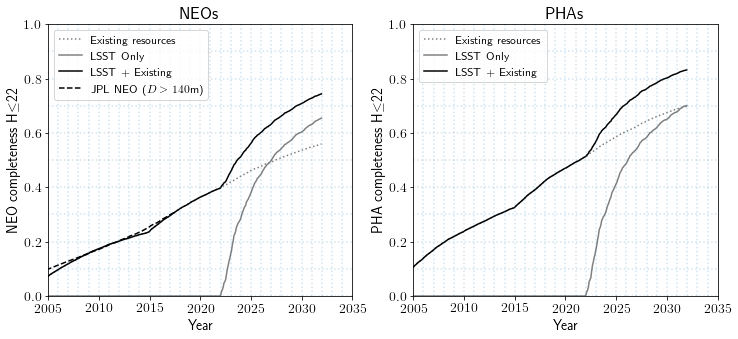

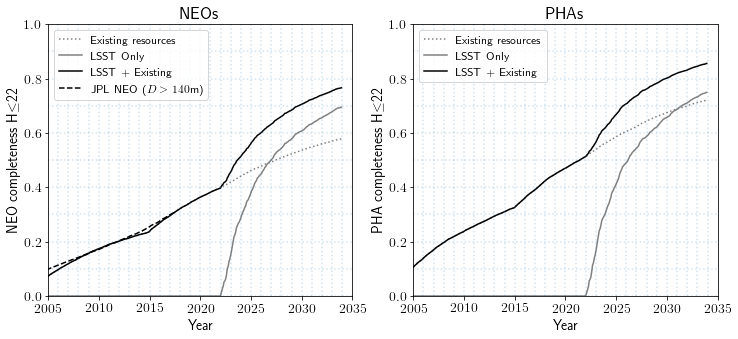

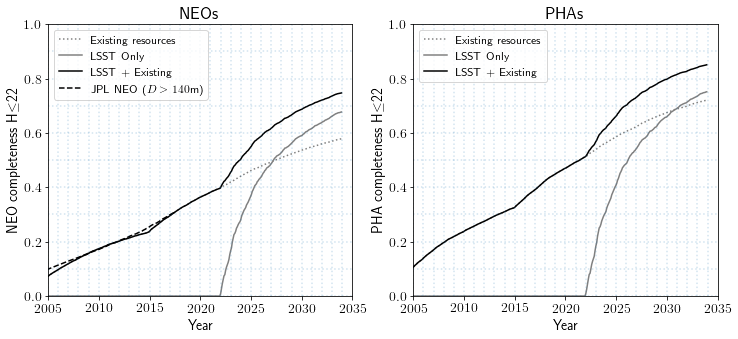

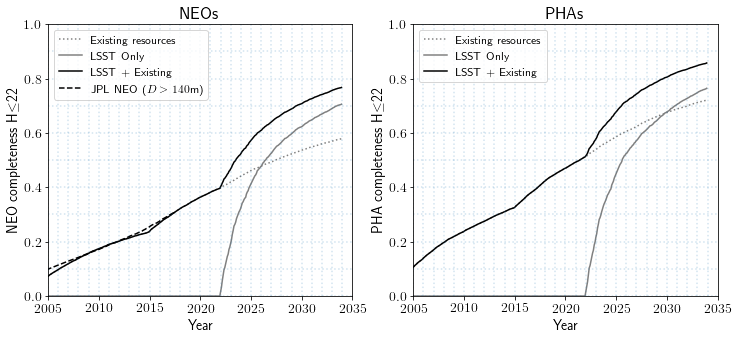

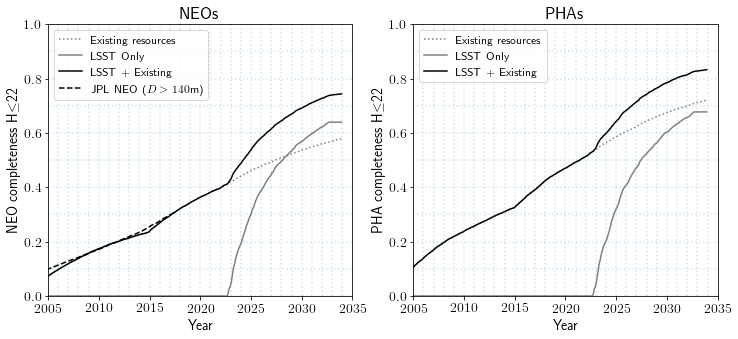

In [75]:
# Plot the cumulative completeness for H<=22 for NEOs (neo22, neo, and neo22+neo) and then PHAs
strategy = '3 pairs in 15 nights'
print(strategy)
for opsim in opsims:
    print('\n', opsim)
    #times = np.arange(51544.16, 63230.16, 120)
    times12 = np.arange(51544.16, 63963.16, 30) 
    times10 = np.arange(51544.16, 63232.16, 30)
    yrs12 = (times12 - 57023)/365.25 + 2015
    yrs10 = (times10 - 57023)/365.25 + 2015
    if opsim == 'minion_1016':
        print('using 10 years')
        yrs = yrs10
        times = times10
    else:
        print('using 12 years')
        yrs = yrs12
        times = times12
    i=0
    plt.figure(figsize=(12, 5))
    plt.rc('text', usetex=True)      
    #plt.rc('font', family='serif')
    plt.rc('font', size=14)
    for t in types:
        i+=1
        comp = {}
        comp['other'] = compTime(known[t].metricValues, Hrange2, times)
        comp['lsst'] = compTime(timebundles[opsim][t][strategy].metricValues, Hrange2, times)
        comp['both'] = compTime(combineTimes(known[t].metricValues, timebundles[opsim][t][strategy].metricValues), 
                                Hrange2, times)
        Hidx = np.where(Hrange2 == 22)[0][0]
        plt.subplot(1,2,i)
        plt.plot(yrs, comp['other'].swapaxes(0,1)[Hidx], color='gray', linestyle=':', label='Existing resources')
        plt.plot(yrs, comp['lsst'].swapaxes(0,1)[Hidx], color='gray', linestyle="-", label='LSST Only')
        plt.plot(yrs, comp['both'].swapaxes(0,1)[Hidx], color='black', label='LSST + Existing')
        if t == 'neo':
            plt.plot(dyrs, neo140rate, color='k', linestyle='--', label=r'JPL NEO ($D>140$m)')
        plt.legend(loc='upper left', fontsize='smaller')
        for y in (np.arange(2005, 2035, 1)):
            plt.axvline(y, alpha=0.2, linestyle=':')
        for i in (np.arange(0, 1.1, 0.1)):
            plt.axhline(i, alpha=0.2, linestyle=':')
        plt.xlim(2005, 2035)
        plt.ylim(0, 1)
        plt.xlabel(r'Year')
        plt.ylabel(r'%s completeness H$\leq$22' % (t.upper()))
        plt.title(r'%ss' % (t.upper()))
        plt.savefig('neo_pha_completeness_3in15_%s.pdf' % (opsim), format='pdf')

        print(t.upper())
        idx_2015 = np.where(abs(yrs-2015) == abs(yrs-2015).min())[0][0]
        idx_2016 = np.where(abs(yrs-2016) == abs(yrs-2016).min())[0][0]
        idx_start = np.where(abs(yrs-2022) == abs(yrs-2022).min())[0][0]
        idx_2032 = np.where(abs(yrs-2032) == abs(yrs-2032).min())[0][0]
        print('At 2015, have %.3f %s completeness from other surveys (%f, %f)' %(comp['other'][idx_2015][Hidx], t.upper(), 
                                                                             times[idx_2015], yrs[idx_2015]))
        print('At 2016, have %.3f %s completeness from other surveys (%f, %f)' %(comp['other'][idx_2016][Hidx], t.upper(), 
                                                                             times[idx_2016], yrs[idx_2016]))
        print('At start of LSST (2022), have %.3f %s completeness from other surveys (%f, %f)' %(comp['other'][idx_start][Hidx], 
                                                                                             t.upper(), times[idx_start], 
                                                                                             yrs[idx_start]))
        print('At 2032, have %.3f %s completeness from other surveys (%f, %f)' %(comp['other'][idx_2032][Hidx], 
                                                                             t.upper(), times[idx_2032], yrs[idx_2032]))
        print('Year %f' %yrs[-1])
        print('LSST only: %.3f' % (comp['lsst'][-1][Hidx]))
        print('LSST + existing surveys: %.3f' % (comp['both'][-1][Hidx]))

        print('Year %f (yr 10)' %yrs[idx_2032])
        print('LSST only: %.3f' % (comp['lsst'][idx_2032][Hidx]))
        print('LSST + existing surveys: %.3f' % (comp['both'][idx_2032][Hidx]))

3 pairs in 30 nights

 minion_1016
using 10 years
NEO
At 2015, have 0.239 NEO completeness from other surveys (57034.160000, 2015.030554)
At 2016, have 0.270 NEO completeness from other surveys (57394.160000, 2016.016181)
At start of LSST (2022), have 0.398 NEO completeness from other surveys (59584.160000, 2022.012074)
At 2032, have 0.560 NEO completeness from other surveys (63214.160000, 2031.950472)
Year 2031.950472
LSST only: 0.675
LSST + existing surveys: 0.757
Year 2031.950472 (yr 10)
LSST only: 0.675
LSST + existing surveys: 0.757
PHA
At 2015, have 0.327 PHA completeness from other surveys (57034.160000, 2015.030554)
At 2016, have 0.362 PHA completeness from other surveys (57394.160000, 2016.016181)
At start of LSST (2022), have 0.513 PHA completeness from other surveys (59584.160000, 2022.012074)
At 2032, have 0.699 PHA completeness from other surveys (63214.160000, 2031.950472)
Year 2031.950472
LSST only: 0.721
LSST + existing surveys: 0.841
Year 2031.950472 (yr 10)
LSST only:

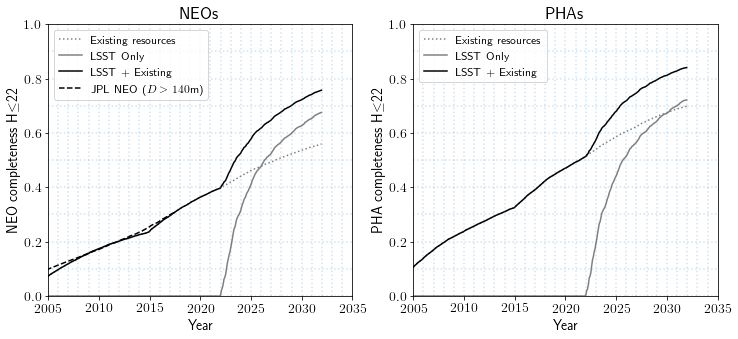

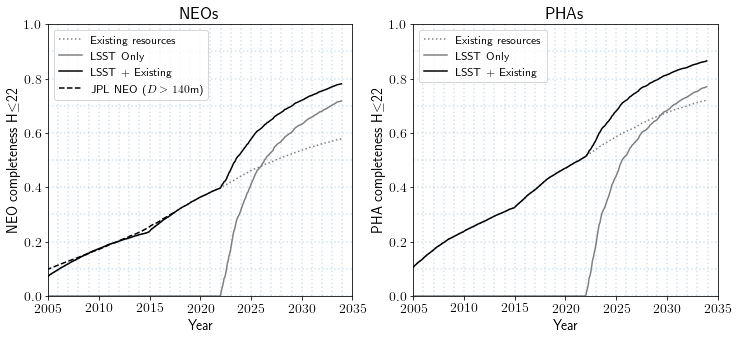

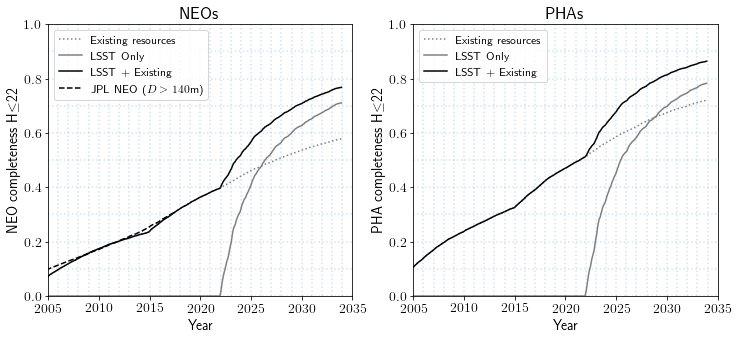

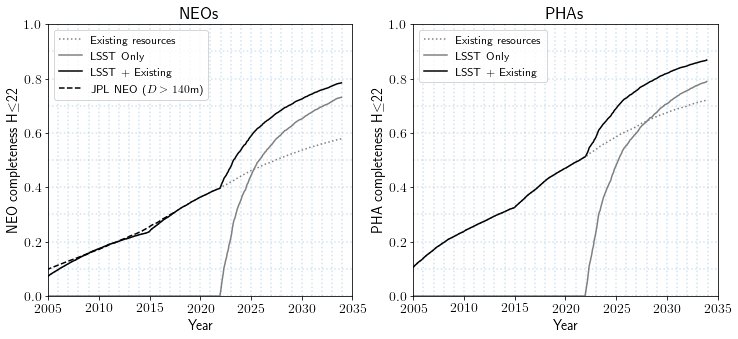

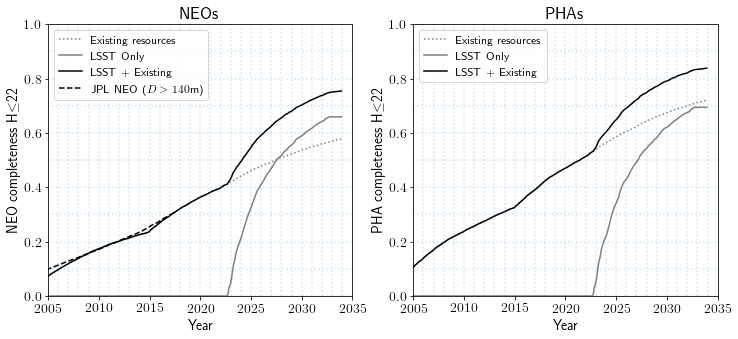

In [74]:
# Plot the cumulative completeness for H<=22 for NEOs (neo22, neo, and neo22+neo) and then PHAs
strategy = '3 pairs in 30 nights'
print(strategy)
for opsim in opsims:
    print('\n', opsim)
    #times = np.arange(51544.16, 63230.16, 120)
    times12 = np.arange(51544.16, 63963.16, 30) 
    times10 = np.arange(51544.16, 63232.16, 30)
    yrs12 = (times12 - 57023)/365.25 + 2015
    yrs10 = (times10 - 57023)/365.25 + 2015
    if opsim == 'minion_1016':
        print('using 10 years')
        yrs = yrs10
        times = times10
    else:
        print('using 12 years')
        yrs = yrs12
        times = times12
    i=0
    plt.figure(figsize=(12, 5))
    plt.rc('text', usetex=True)      
    #plt.rc('font', family='serif')
    plt.rc('font', size=14)
    for t in types:
        i+=1
        comp = {}
        comp['other'] = compTime(known[t].metricValues, Hrange2, times)
        comp['lsst'] = compTime(timebundles[opsim][t][strategy].metricValues, Hrange2, times)
        comp['both'] = compTime(combineTimes(known[t].metricValues, timebundles[opsim][t][strategy].metricValues), 
                                Hrange2, times)
        Hidx = np.where(Hrange2 == 22)[0][0]
        plt.subplot(1,2,i)
        plt.plot(yrs, comp['other'].swapaxes(0,1)[Hidx], color='gray', linestyle=':', label='Existing resources')
        plt.plot(yrs, comp['lsst'].swapaxes(0,1)[Hidx], color='gray', linestyle="-", label='LSST Only')
        plt.plot(yrs, comp['both'].swapaxes(0,1)[Hidx], color='black', label='LSST + Existing')
        if t == 'neo':
            plt.plot(dyrs, neo140rate, color='k', linestyle='--', label=r'JPL NEO ($D>140$m)')
        plt.legend(loc='upper left', fontsize='smaller')
        start_year = 2005
        for y in (np.arange(start_year, 2035, 1)):
            plt.axvline(y, alpha=0.2, linestyle=':')
        for i in (np.arange(0, 1.1, 0.1)):
            plt.axhline(i, alpha=0.2, linestyle=':')
        plt.xlim(start_year, 2035)
        plt.ylim(0, 1)
        plt.xlabel(r'Year')
        plt.ylabel(r'%s completeness H$\leq$22' % (t.upper()))
        plt.title(r'%ss' % (t.upper()))
        plt.savefig('neo_pha_completeness_3in30_%s.pdf' % (opsim), format='pdf')

        print(t.upper())
        idx_2015 = np.where(abs(yrs-2015) == abs(yrs-2015).min())[0][0]
        idx_2016 = np.where(abs(yrs-2016) == abs(yrs-2016).min())[0][0]
        idx_start = np.where(abs(yrs-2022) == abs(yrs-2022).min())[0][0]
        idx_2032 = np.where(abs(yrs-2032) == abs(yrs-2032).min())[0][0]
        print('At 2015, have %.3f %s completeness from other surveys (%f, %f)' %(comp['other'][idx_2015][Hidx], t.upper(), 
                                                                             times[idx_2015], yrs[idx_2015]))
        print('At 2016, have %.3f %s completeness from other surveys (%f, %f)' %(comp['other'][idx_2016][Hidx], t.upper(), 
                                                                             times[idx_2016], yrs[idx_2016]))
        print('At start of LSST (2022), have %.3f %s completeness from other surveys (%f, %f)' %(comp['other'][idx_start][Hidx], 
                                                                                             t.upper(), times[idx_start], 
                                                                                             yrs[idx_start]))
        print('At 2032, have %.3f %s completeness from other surveys (%f, %f)' %(comp['other'][idx_2032][Hidx], 
                                                                             t.upper(), times[idx_2032], yrs[idx_2032]))
        print('Year %f' %yrs[-1])
        print('LSST only: %.3f' % (comp['lsst'][-1][Hidx]))
        print('LSST + existing surveys: %.3f' % (comp['both'][-1][Hidx]))

        print('Year %f (yr 10)' %yrs[idx_2032])
        print('LSST only: %.3f' % (comp['lsst'][idx_2032][Hidx]))
        print('LSST + existing surveys: %.3f' % (comp['both'][idx_2032][Hidx]))